### Time Series Anomaly Detection using LSTM Autoencoders

使用真实世界的心电图ECG来检测患者的心跳异常的情况。我们构建一个LSTM的自编码器，在一组正常的心跳数据上进行训练同时在新样本上做预测判断是否正常。

主要内容包括：
1. 构建一个异常检测的数据集用于时间序列数据的训练
2. 通过PyTorch构建一个LSTM自编码器
3. 训练并评估模型
4. 选择一个阈值用来进行异常检测
5. 对于新样本进行正常或者异常的分类

In [1]:
#!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

In [2]:
#!unzip -qq ECG5000.zip

In [3]:
import torch

import copy
import numpy as np 
import pandas as pd 
import seaborn as sns
from pylab import rcParams
from matplotlib import rc 
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p

In [4]:
device = torch.device("cpu")

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [6]:
with open('ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

In [7]:
with open('ECG5000_TEST.arff') as f:
    test = a2p.load(f)

In [8]:
df = train.append(test)

In [9]:
df = df.sample(frac=1.0)

In [10]:
df

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,-0.248881,-1.346474,-1.855199,-2.519039,-2.947360,-3.233288,-3.087431,-2.668242,-1.970671,-1.390033,...,-1.157266,-1.605818,-2.286109,-3.247334,-3.551343,-3.426098,-2.171479,-1.380595,-0.378163,2
466,-0.287286,-1.199089,-1.563916,-2.078314,-2.456073,-2.508211,-2.465002,-2.445333,-2.320656,-1.995150,...,-2.061417,-2.679767,-3.228270,-3.584828,-3.629377,-3.000843,-2.079477,-1.307187,0.075742,2
2592,-1.032096,-2.811901,-3.588706,-3.883206,-3.279964,-2.275187,-1.771033,-1.603019,-0.956392,-0.764538,...,1.280471,1.353143,1.526594,1.429218,1.099634,1.245052,1.568047,1.776520,0.750669,1
3272,-1.592541,-2.461370,-2.524132,-3.062815,-2.968224,-2.784655,-2.738399,-2.431311,-2.063169,-1.555809,...,-2.179744,-2.624303,-3.107874,-3.102964,-2.746384,-1.972664,-1.077676,-0.707541,0.354016,2


In [11]:
CLASS_NORMAL = 1

In [12]:
class_names = ['Normal','R on T','PVC', 'SP', 'UB']

In [13]:
new_columns = list(df.columns)

In [14]:
new_columns[-1] = 'target'

In [15]:
new_columns

['att1@NUMERIC',
 'att2@NUMERIC',
 'att3@NUMERIC',
 'att4@NUMERIC',
 'att5@NUMERIC',
 'att6@NUMERIC',
 'att7@NUMERIC',
 'att8@NUMERIC',
 'att9@NUMERIC',
 'att10@NUMERIC',
 'att11@NUMERIC',
 'att12@NUMERIC',
 'att13@NUMERIC',
 'att14@NUMERIC',
 'att15@NUMERIC',
 'att16@NUMERIC',
 'att17@NUMERIC',
 'att18@NUMERIC',
 'att19@NUMERIC',
 'att20@NUMERIC',
 'att21@NUMERIC',
 'att22@NUMERIC',
 'att23@NUMERIC',
 'att24@NUMERIC',
 'att25@NUMERIC',
 'att26@NUMERIC',
 'att27@NUMERIC',
 'att28@NUMERIC',
 'att29@NUMERIC',
 'att30@NUMERIC',
 'att31@NUMERIC',
 'att32@NUMERIC',
 'att33@NUMERIC',
 'att34@NUMERIC',
 'att35@NUMERIC',
 'att36@NUMERIC',
 'att37@NUMERIC',
 'att38@NUMERIC',
 'att39@NUMERIC',
 'att40@NUMERIC',
 'att41@NUMERIC',
 'att42@NUMERIC',
 'att43@NUMERIC',
 'att44@NUMERIC',
 'att45@NUMERIC',
 'att46@NUMERIC',
 'att47@NUMERIC',
 'att48@NUMERIC',
 'att49@NUMERIC',
 'att50@NUMERIC',
 'att51@NUMERIC',
 'att52@NUMERIC',
 'att53@NUMERIC',
 'att54@NUMERIC',
 'att55@NUMERIC',
 'att56@NUMERIC',
 

In [16]:
df.columns = new_columns

In [17]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

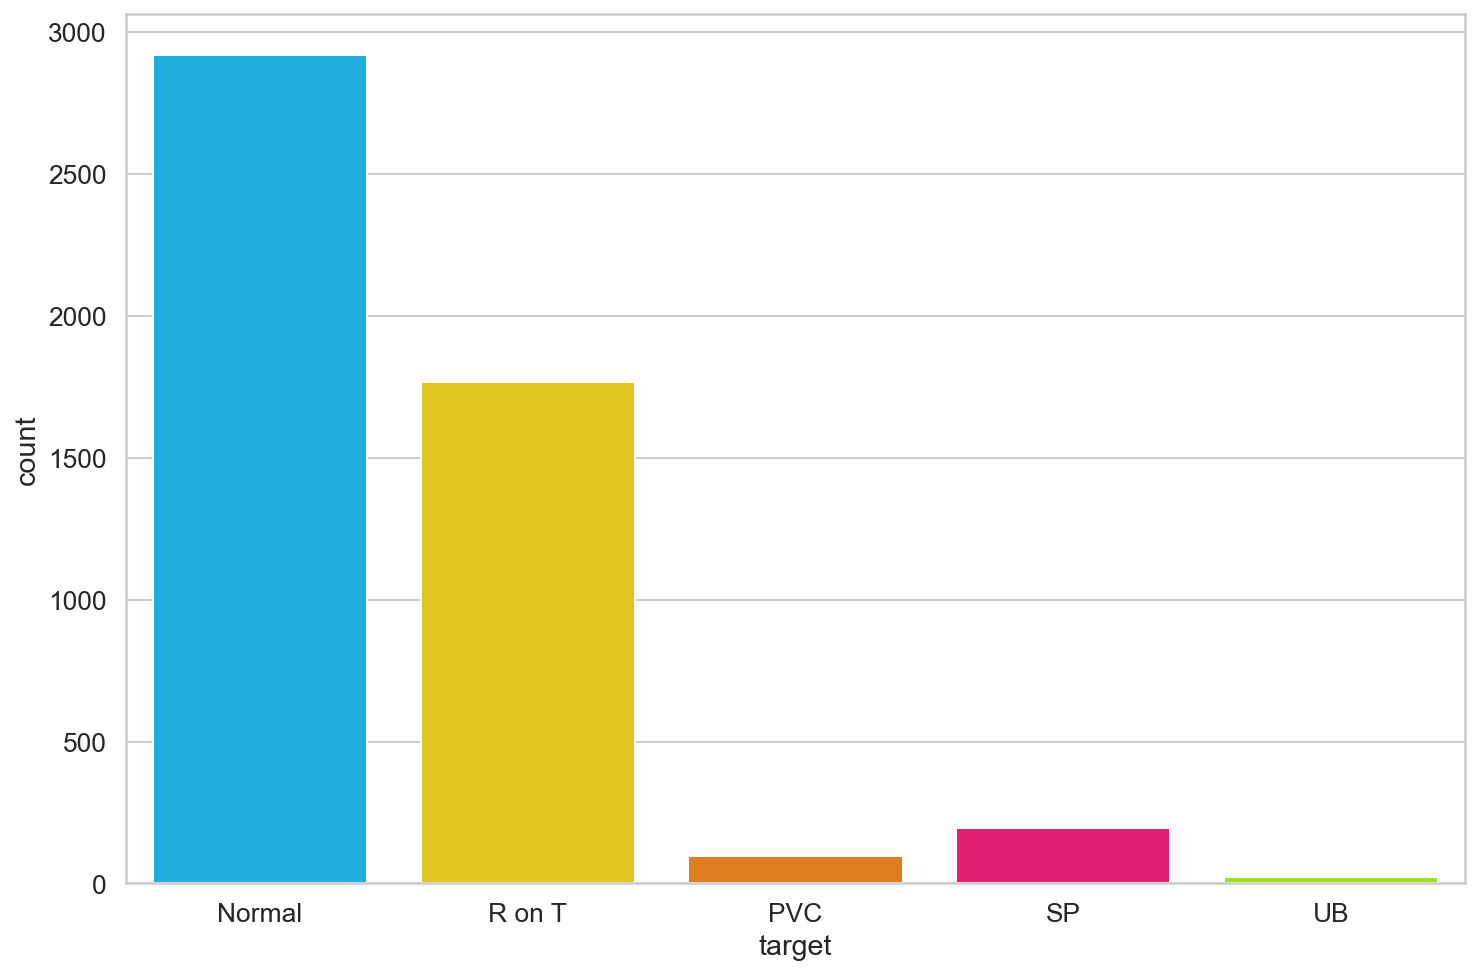

In [18]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [19]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)
    
    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()
    
    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]
    
    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

绘图观察每一个类别的时间序列的平均值的情况，中间蓝色的表示平均值（在n_steps下求的平均），覆盖的浅蓝色区域的上下界表示的标准的偏差平滑

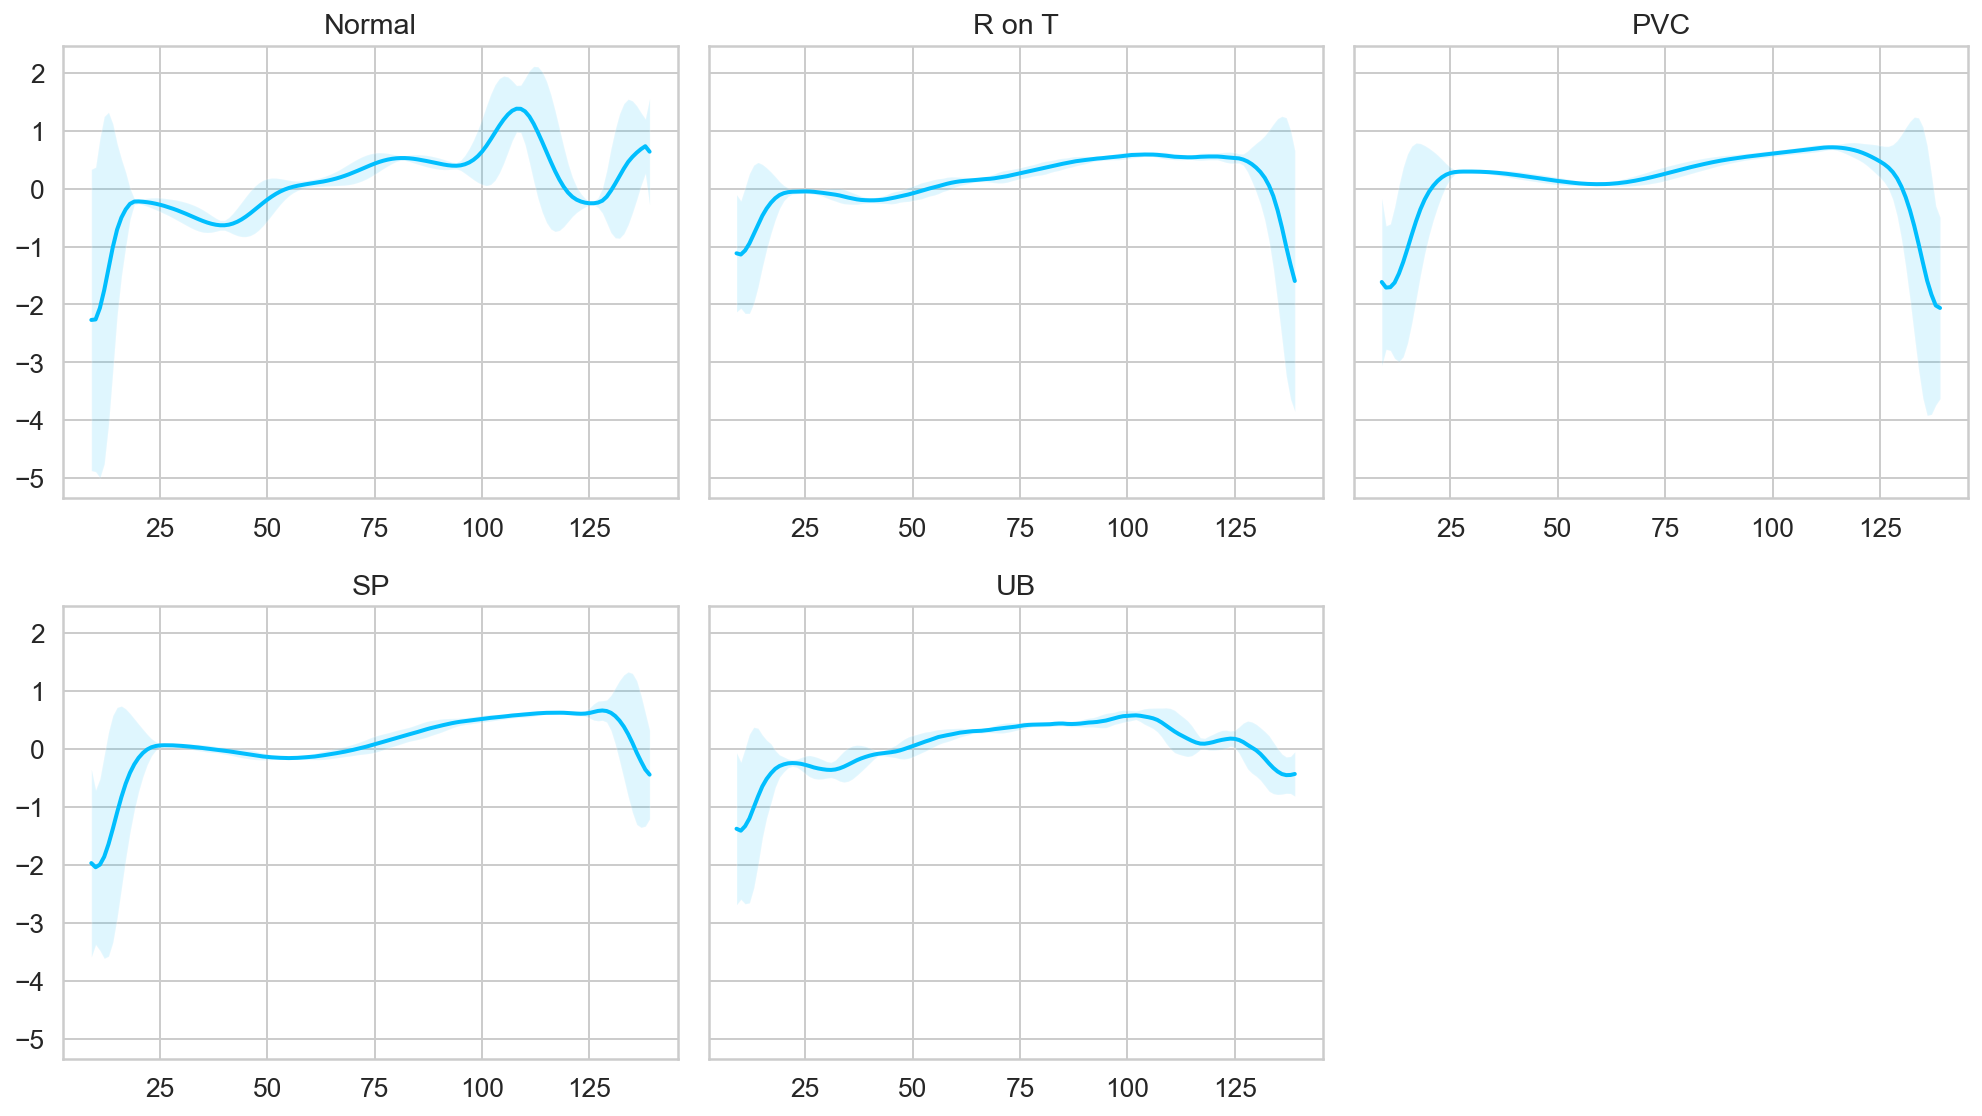

In [20]:
import matplotlib.pyplot as plt
classes = df.target.unique()

fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14,8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target==cls].drop(labels='target',axis=1).mean(axis=0).to_numpy()
    plot_time_series_class(data, class_names[i], ax)
    
fig.delaxes(axs.flat[-1])
fig.tight_layout();

#### LSTM Autoencoder
自编码器是一个这样的模型：给一些输入数据，经过自编码器后他会得到一个输入数据的重建结果，这个重建结果会尽可能地与输入结果匹配。使用较少的参数，这个模型就可以学习到关于我的输入数据的压缩表示，这是这个模型的诀窍。

某种意义上来说自编码器尝试去学习数据最重要的那部分特征。下面我们将时间序列的数据放入自编码器中。

In [21]:
'''
数据预处理
'''
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)

In [22]:
normal_df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.509497,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.299639,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676


In [23]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target',axis=1)

In [24]:
anomaly_df.shape

(2081, 140)

In [25]:
'''
将正常的样本数据划分为训练集，验证集以及测试集 
'''
train_df,val_df = train_test_split(normal_df,test_size=0.15,random_state=RANDOM_SEED)

val_df,test_df = train_test_split(val_df,test_size=0.33,random_state=RANDOM_SEED)

In [26]:
print('train.shape{},test.shape{},val.shape{}'.format(train_df.shape,test_df.shape,val_df.shape))

train.shape(2481, 140),test.shape(145, 140),val.shape(293, 140)


In [27]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [28]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _=create_dataset(val_df)
test_normal_dataset, _, _=create_dataset(test_df)
test_anomaly_dataset, _, _=create_dataset(anomaly_df)

In [29]:
'''
构建自编码器的编码部分
这个编码部分使用了两个LSTM层来对时间序列的数据输入进行压缩处理
'''
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        
        self.rnn1 = nn.LSTM(
            input_size = n_features,
            hidden_size = self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size = self.hidden_dim,
            hidden_size = embedding_dim,
            num_layers = 1,
            batch_first = True
        )

    def forward(self, x):
        x = x.reshape((1,self.seq_len, self.n_features))
        
        x, (_,_) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        
        return hidden_n.reshape((self.n_features,self.embedding_dim))

In [30]:
'''
下面构建自编码器的解码部分
这个解码部分也包含了两个LSTM层和一个输出层，这个输出层给出的最终的重构结果
'''
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2*input_dim
        self.n_features = n_features
        
        self.rnn1 = nn.LSTM(
            input_size = input_dim,
            hidden_size = input_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.rnn2 = nn.LSTM(
            input_size = input_dim,
            hidden_size = self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
        
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        
        x, (hidden_n,cell_n) = self.rnn1(x)
        x, (hidden_n,cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        
        return self.output_layer(x)

In [31]:
'''
下面将上面的编码部分和解码部分汇集到一个模块中 
'''
class RecurrentAutoencoder(nn.Module):
    
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder,self).__init__()

        self.encoder = Encoder(seq_len,n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len,embedding_dim,n_features).to(device)
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x 

In [32]:
model = RecurrentAutoencoder(seq_len,n_features,128)

In [33]:
model = model.to(device)

In [34]:
'''
构建一个函数用于我们的训练过程 
'''
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[],val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    for epoch in range(1,n_epochs+1):
        model = model.train()
        
        train_losses  = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred,seq_true)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [35]:
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=150
)

Epoch 1: train loss 69.50555047370023 val loss 52.80555995902104
Epoch 2: train loss 52.967535792315786 val loss 51.10272222004653
Epoch 3: train loss 47.12122427384155 val loss 33.97116223618439
Epoch 4: train loss 34.194739457437564 val loss 36.74264707988439
Epoch 5: train loss 29.866721468844368 val loss 29.580316774674245
Epoch 6: train loss 27.30142477143921 val loss 28.826090841976857
Epoch 7: train loss 26.490193800981945 val loss 23.89333370521207
Epoch 8: train loss 25.837484980532835 val loss 24.212265538681084
Epoch 9: train loss 24.90620653497649 val loss 23.845960835141128
Epoch 10: train loss 24.147891778803697 val loss 22.245721240906178
Epoch 11: train loss 24.09430874359795 val loss 25.727128533373108
Epoch 12: train loss 23.335445392521002 val loss 23.344031496666396
Epoch 13: train loss 22.088666165177738 val loss 21.66468362840776
Epoch 14: train loss 21.531034056384062 val loss 22.468647061761327
Epoch 15: train loss 21.022920066144668 val loss 21.17252410393933
E

Epoch 123: train loss 13.637486787440075 val loss 14.386160627566914
Epoch 124: train loss 13.297918571093927 val loss 14.120282414016463
Epoch 125: train loss 12.900906761343178 val loss 15.915362911419656
Epoch 126: train loss 12.975608256784767 val loss 12.430581714512952
Epoch 127: train loss 12.784141261459405 val loss 11.31667664596245
Epoch 128: train loss 12.411281674103313 val loss 12.204935539297683
Epoch 129: train loss 12.33033604373955 val loss 11.543059716859368
Epoch 130: train loss 12.247250447009947 val loss 12.416919750565148
Epoch 131: train loss 12.294950114292082 val loss 11.179679615098868
Epoch 132: train loss 11.961622915264101 val loss 13.910589974894865
Epoch 133: train loss 12.135720406939358 val loss 20.88349900554878
Epoch 134: train loss 11.698971124293102 val loss 11.530498416757421
Epoch 135: train loss 11.628723604070808 val loss 11.398122409911693
Epoch 136: train loss 11.805705390885587 val loss 12.550537893796538
Epoch 137: train loss 11.807502833454

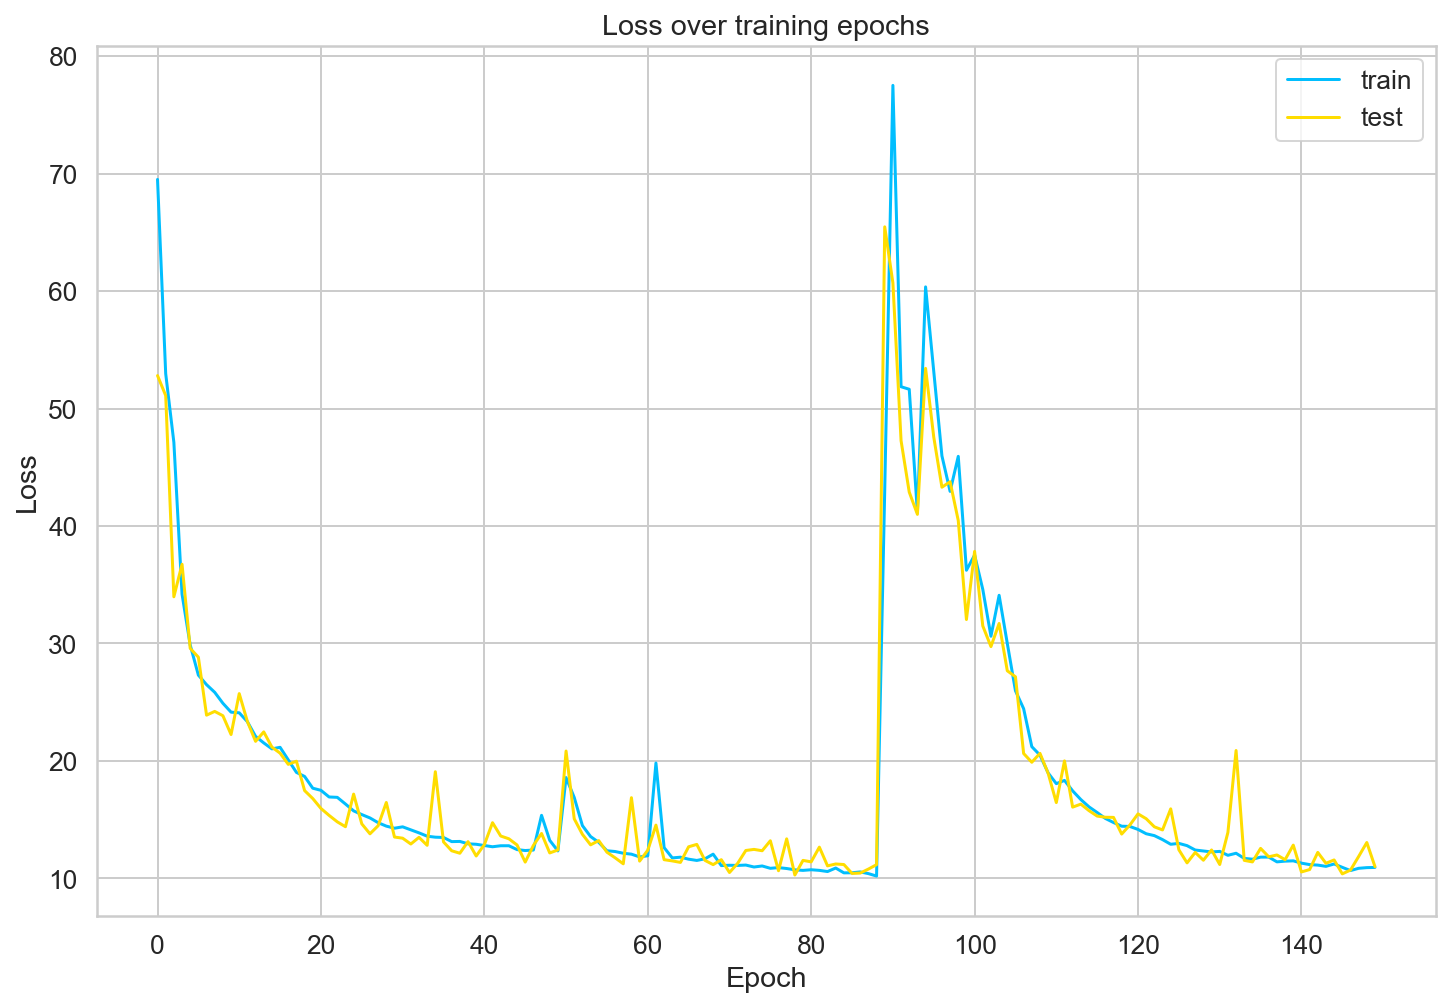

In [36]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.title('Loss over training epochs')
plt.show();

emmm……这个训练结果就很可惜，中间出现了大的跳跃波动，训练大概80个epochs的loss和训练150个epochs的结果差不太多，甚至更好一些。

In [37]:
MODEL_PATH = 'LSTM_MODEL.pth'
torch.save(model, MODEL_PATH)

D:\Software\Anconda\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RecurrentAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Software\Anconda\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
D:\Software\Anconda\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [41]:
'''
现在已经将训练好的模型保存起来了下面的任务去寻找一个阈值同时去对新的数据进行预测
'''
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            
            loss = criterion(seq_pred, seq_true)
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

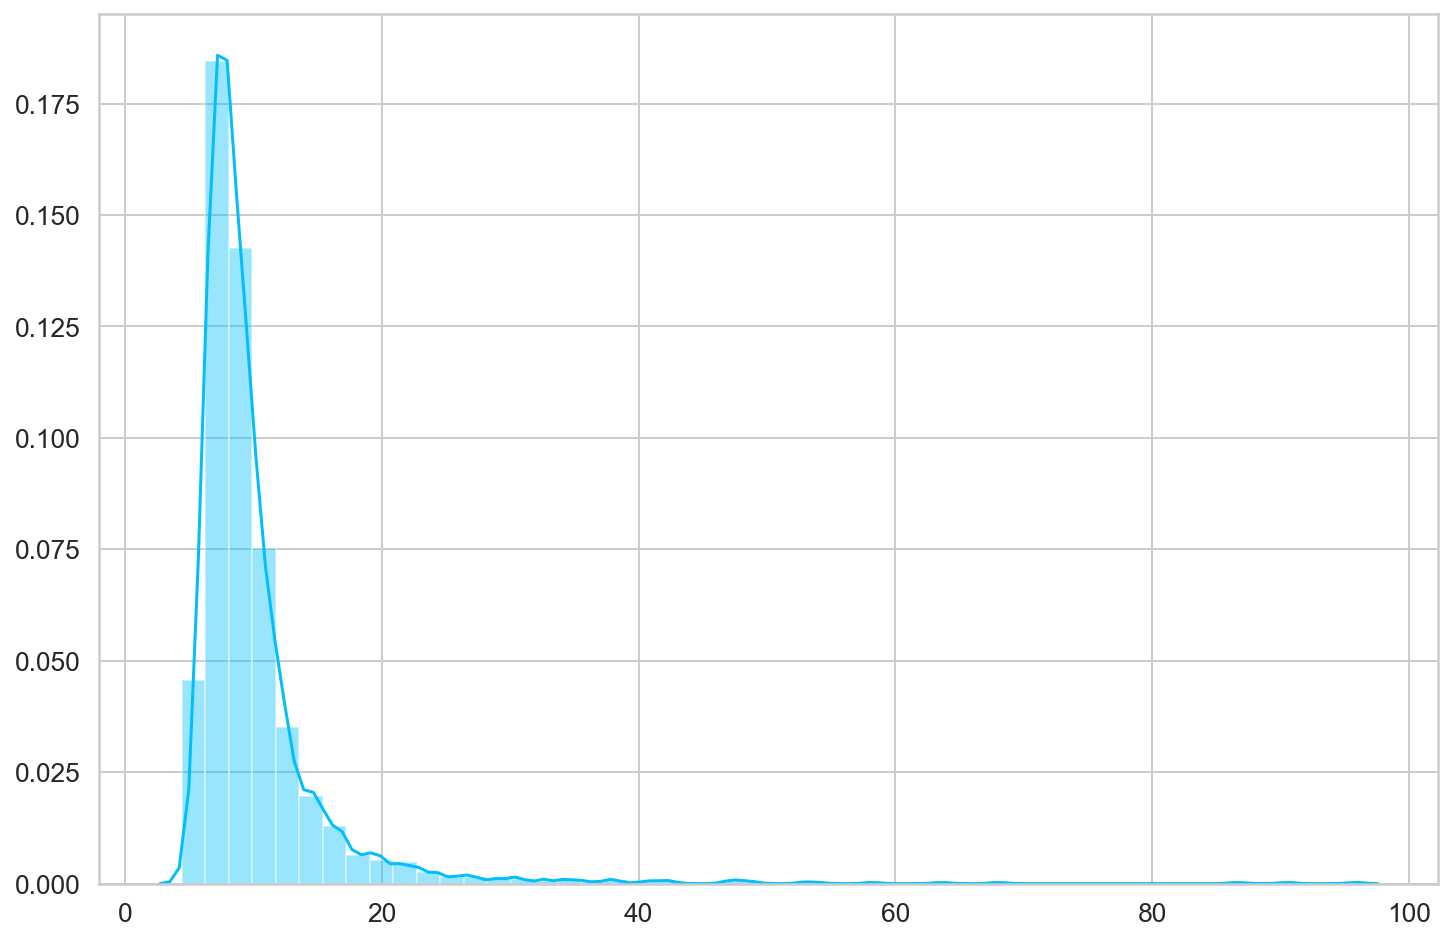

In [42]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True)

In [43]:
THRESHOLD = 26

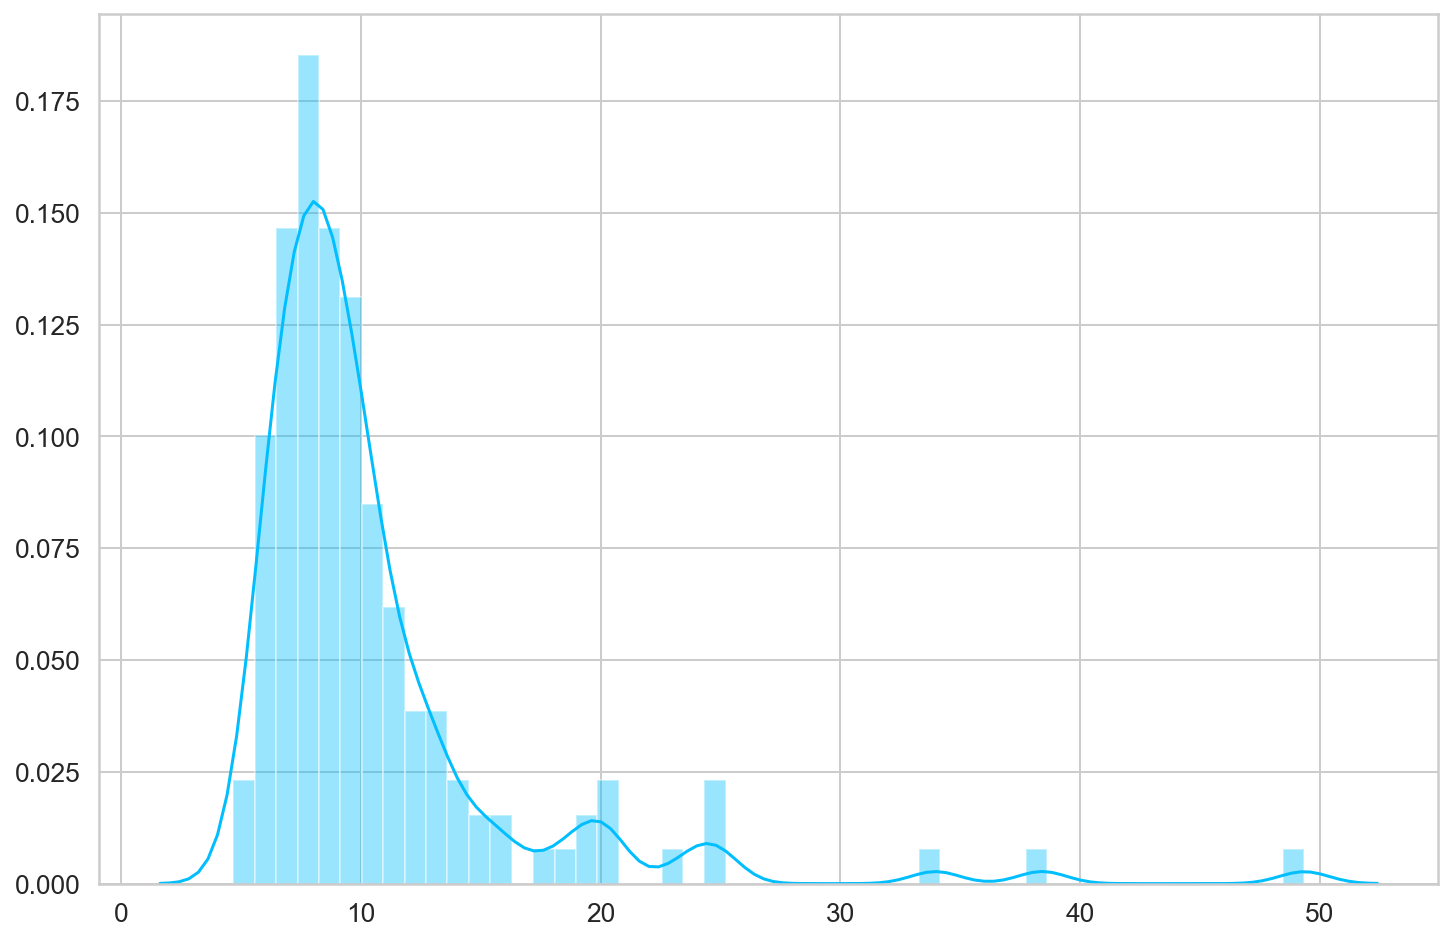

In [44]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [45]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 142/145


In [46]:
anomaly_dataset = test_anomaly_dataset[:len(test_anomaly_dataset)]

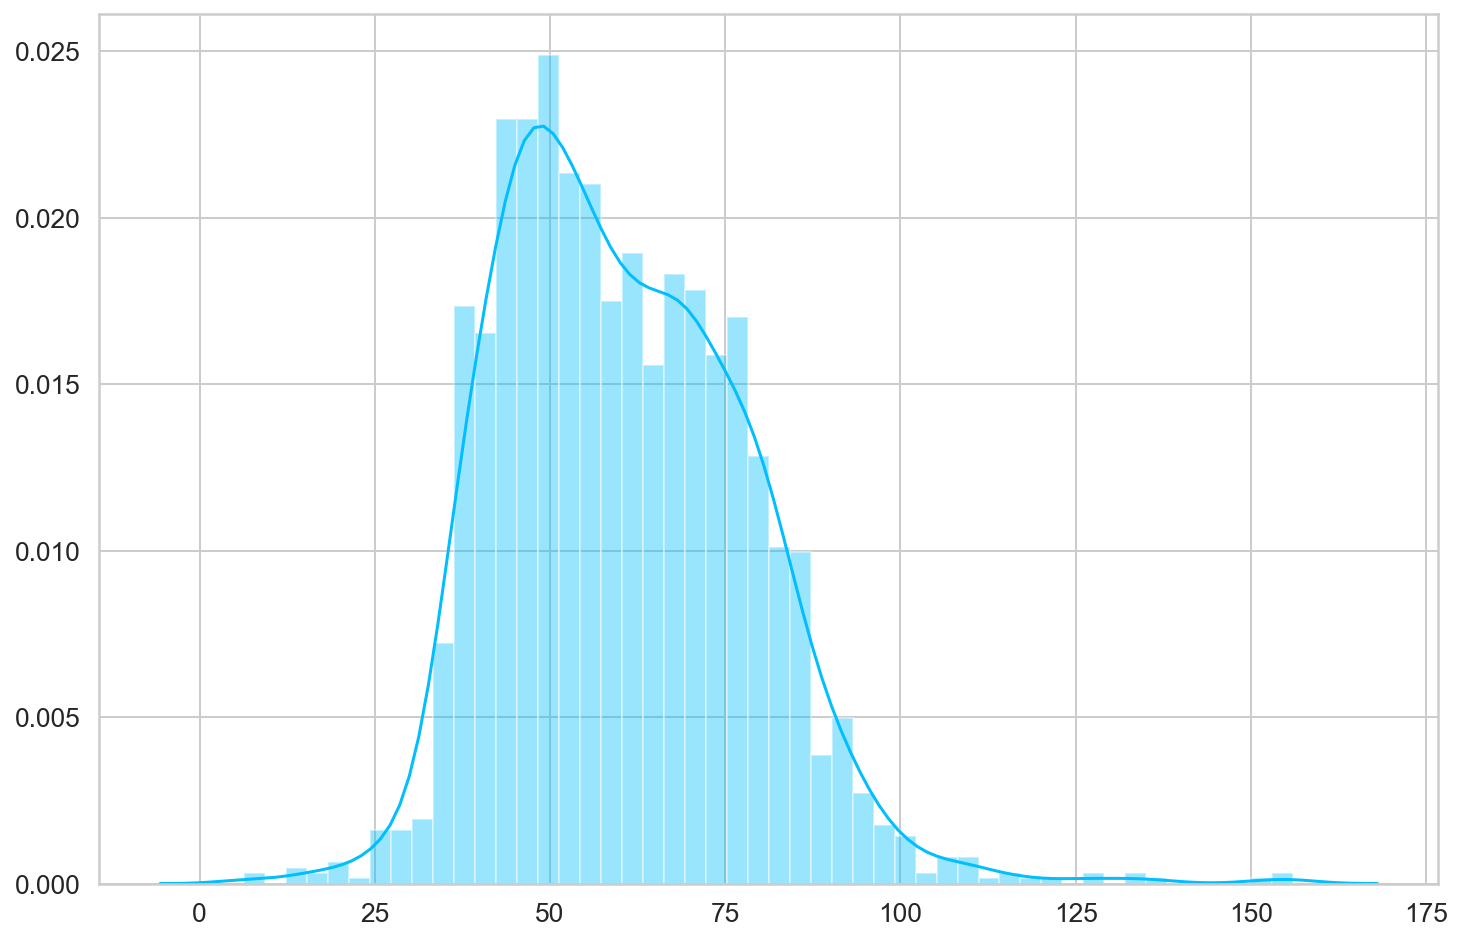

In [47]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [48]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct Anomaly Predictions: {correct}/{len(anomaly_dataset)}')

Correct Anomaly Predictions: 2066/2081


In [49]:
def plot_predictions(data, model, title, ax):
    predictions, pred_losses = predict(model, [data])
    
    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
    ax.legend()

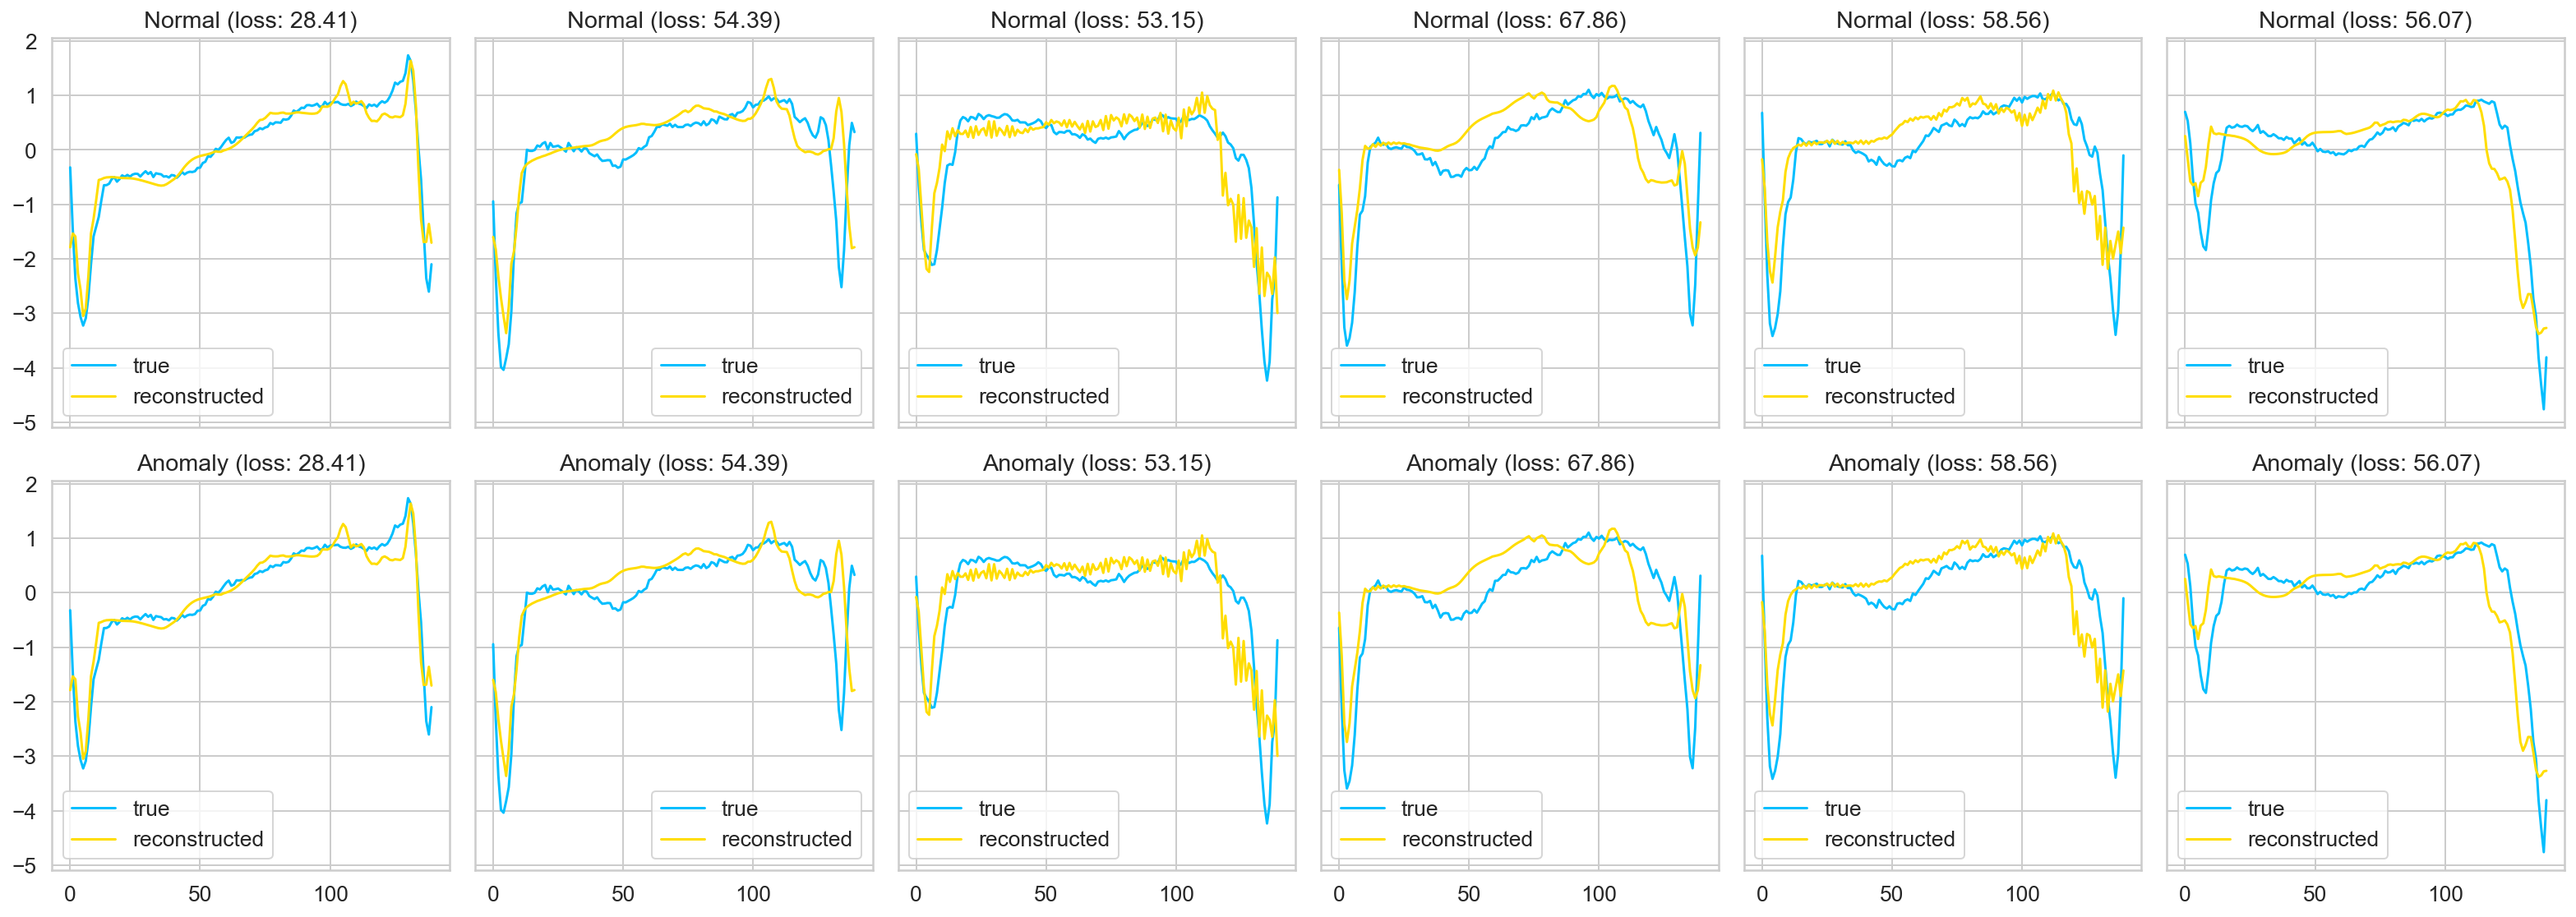

In [50]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=6,
    sharex=True,
    sharey=True,
    figsize=(22,8)
)

for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_predictions(data, model, title='Normal', ax=axs[0,i])
    
for i, data in enumerate(test_anomaly_dataset[:6]):
    plot_predictions(data, model, title='Anomaly', ax=axs[1,i])

fig.tight_layout();

#### Summary

1. 对于时序数据的异常检测问题上如何构建一个数据集
2. 使用Pytorch构建一个LSTM的自编码器
3. 训练以及评估构建的模型
4. 对于异常检测选择一个阈值
5. 使用训练好的模型对于未知样本进行测试，观察其是否正常